In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 42, 'n_sample_ratio': 1.0}


1it [00:06,  6.77s/it]

n_sample_ratio=1.0


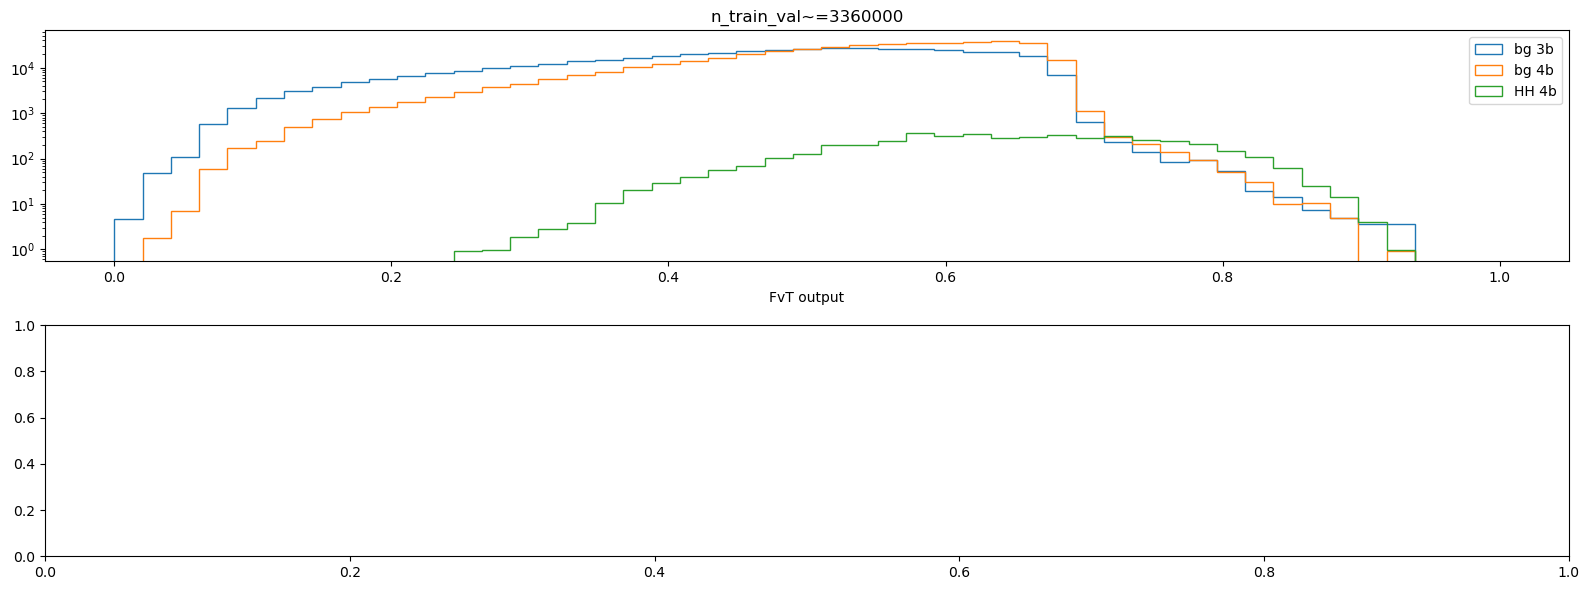

In [3]:
import torch
from dataset import generate_tt_dataset
from training_info import TrainingInfo
import pytorch_lightning as pl
import yaml
from fvt_classifier import FvTClassifier
from code_fragments import fvt_score_hist
from events_data import EventsData
import tqdm
import numpy as np
import matplotlib.pyplot as plt

config_filename = "configs/fvt_training_n_samples_1.yml"


config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
n_all4b = config["n_all4b"]
signal_ratio = config["signal_ratio"]
test_ratio = config["test_ratio"]
# n_sample_ratios = config["n_sample_ratios"]
n_sample_ratios = [1.0]
seeds = [42]
w_cuts = np.arange(0.01, 1.01, 0.01)

fvt_scores_dict = {seed: {} for seed in seeds}
att_q_reprs_dict = {seed: {} for seed in seeds}
events_test_dict = {}
fvt_models_dict = {seed: {} for seed in seeds}

for seed in seeds:
    _, dinfo_test = generate_tt_dataset(
            seed,
            n_3b,
            n_all4b,
            signal_ratio,
            test_ratio,
        )
    events_test = EventsData.from_dataframe(dinfo_test.fetch_data(), features)
    events_test_dict[seed] = events_test

    nrows = 2
    ncols = int(np.ceil(len(n_sample_ratios) / 2))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))

    for ax_cnt, n_sample_ratio in tqdm.tqdm(enumerate(n_sample_ratios)):
        hparam_filter = {"experiment_name": experiment_name, 
                         "seed": seed, 
                         "n_sample_ratio": n_sample_ratio}
        hashes = TrainingInfo.find(hparam_filter)
        assert len(hashes) == 1
        print("successfully loaded", hparam_filter)
        hash = hashes[0]
        tinfo = TrainingInfo.load(hash)
        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()

        current_ax = ax[ax_cnt // ncols, ax_cnt % ncols] if ncols > 1 else ax[ax_cnt]
        current_ax.set_title(f"n_train_val~={1000 * ((len(tinfo.dinfo_train) + len(tinfo.dinfo_val)) // 1000)}")
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        events_test.set_model_scores(fvt_model)
        fvt_score_hist(events_test, current_ax, logscale=True)
        
        print(f"n_sample_ratio={n_sample_ratio}")
        # att_q_repr_hist(events_test, title=f"n_sample_ratio={n_sample_ratio}")

        fvt_scores_dict[seed][n_sample_ratio] = events_test.fvt_score
        att_q_reprs_dict[seed][n_sample_ratio] = events_test.att_q_repr
        fvt_models_dict[seed][n_sample_ratio] = fvt_model

    fig.tight_layout()
    fig.show()

    plt.show()
    plt.close()

In [23]:
tinfo.dinfo_train.overwrite_features["weight"].nbytes / 2**20

8.587646484375

In [13]:
(tinfo.dinfo_train.file_idx.nbytes + tinfo.dinfo_train.inner_idx.nbytes) / 2**20


34.3505859375

In [25]:
import pandas as pd
from pathlib import Path

directory = Path("../events/MG3")
df_3b = pd.read_hdf(directory / "dataframes" / "threeTag_picoAOD.h5")
df_bg4b = pd.read_hdf(directory / "dataframes" / "fourTag_10x_picoAOD.h5")
df_signal = pd.read_hdf(directory / "dataframes" / "HH4b_picoAOD.h5")

In [29]:
indices_3b = np.full(len(df_3b), False)

In [30]:
%timeit indices_3b[np.random.choice(len(df_3b), n_3b, replace=False)] = True

15.8 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
np.argmin(np.cumsum(x) < 0)

0

In [54]:
x = np.arange(100)
np.argmax(np.cumsum(x) >= 100)
np.sum(x[:14])


91

In [55]:
df_3b.columns

Index(['Jet0_pt', 'Jet1_pt', 'Jet2_pt', 'Jet3_pt', 'Jet0_eta', 'Jet1_eta',
       'Jet2_eta', 'Jet3_eta', 'Jet0_phi', 'Jet1_phi', 'Jet2_phi', 'Jet3_phi',
       'Jet0_m', 'Jet1_m', 'Jet2_m', 'Jet3_m', 'weight', 'fourTag', 'm01',
       'm23', 'm02', 'm13', 'm03', 'm12', 'pt01', 'pt23', 'pt02', 'pt13',
       'pt03', 'pt12', 'dR01', 'dR23', 'dR02', 'dR13', 'dR03', 'dR12',
       'dR0123', 'dR0213', 'dR0312', 'mZZ0123', 'mZZ0213', 'mZZ0312', 's4j',
       'm4j', 'sym_Jet0_eta', 'sym_Jet1_eta', 'sym_Jet2_eta', 'sym_Jet3_eta',
       'sym_Jet1_phi', 'sym_Jet2_phi', 'sym_Jet3_phi', 'sym_Jet0_phi',
       'sym_Jet0_pt', 'sym_Jet0_m', 'sym_Jet1_pt', 'sym_Jet1_m', 'sym_Jet2_pt',
       'sym_Jet2_m', 'sym_Jet3_pt', 'sym_Jet3_m'],
      dtype='object')

In [28]:
print(df_3b["weight"].mean())
print(df_bg4b["weight"].mean())
print(df_signal["weight"].mean())


1.1424559
1.043426
1.069797


In [124]:
from dataset import generate_mother_dataset

seed = 42
n_3b = 100_000
ratio_4b = 0.5
signal_ratio = 0.0

scdinfo, df = generate_mother_dataset(n_3b, ratio_4b, signal_ratio, "HH4b_picoAOD.h5", seed)
assert np.all(scdinfo.fetch_data()["weight"] == df["weight"])

is_signal = df["signal"]
is_bg4b = df["fourTag"] & ~is_signal
is_3b = ~df["fourTag"]
is_4b = df["fourTag"]


print(np.sum(df.loc[is_signal, "weight"]) / np.sum(df.loc[is_4b, "weight"]), signal_ratio)
print(np.sum(df.loc[is_4b, "weight"]) / np.sum(df.loc[:, "weight"]), ratio_4b)


0.0 0.0
0.5000019 0.5


# Write the following as a formal test code

In [141]:
assert df.iloc[1]["weight"] == scdinfo[1].fetch_data()["weight"].values

idx = np.random.choice(len(df), 10)
idx_sorted = np.sort(idx)
assert np.all(df["weight"].iloc[idx_sorted] == scdinfo[idx_sorted].fetch_data()["weight"].values)

idx = np.random.choice(len(df), 10)
idx_sorted = np.sort(idx)
assert np.all(df["weight"].iloc[idx_sorted] == scdinfo[idx].fetch_data()["weight"].values)

idx = np.random.choice(len(df), 10)
idx_bool = np.full(len(df), False)
idx_bool[idx] = True
assert np.all(df["weight"].iloc[idx_bool] == scdinfo[idx_bool].fetch_data()["weight"].values)

In [144]:
from dataset import split_scdinfo, SCDatasetInfo

scdinfo1, scdinfo2 = split_scdinfo(scdinfo, 0.5, seed=42)
df1, df2 = SCDatasetInfo.fetch_multiple_data([scdinfo1, scdinfo2])

In [94]:
from dataset import split_scdinfo

dinfo_11, dinfo_21 = split_scdinfo(scdinfo, 2/3, seed=52)
dinfo_12, dinfo_22 = split_scdinfo(scdinfo, 2/3, seed=52)

assert np.all(dinfo_11.fetch_data()["weight"] == dinfo_12.fetch_data()["weight"])
assert np.all(dinfo_21.fetch_data()["weight"] == dinfo_22.fetch_data()["weight"])


In [171]:
display(df_3b.sample(frac=1, random_state=42).head())
display(df_bg4b.sample(frac=1, random_state=42).head())

,Jet0_pt,Jet1_pt,Jet2_pt,Jet3_pt,Jet0_eta,Jet1_eta,Jet2_eta,Jet3_eta,Jet0_phi,Jet1_phi,...,sym_Jet3_phi,sym_Jet0_phi,sym_Jet0_pt,sym_Jet0_m,sym_Jet1_pt,sym_Jet1_m,sym_Jet2_pt,sym_Jet2_m,sym_Jet3_pt,sym_Jet3_m
450175,104.255219,59.362324,55.447792,43.407825,0.464441,1.797849,-0.218295,-2.390903,-0.379814,-0.821206,...,-2.873948,0,104.255219,0.0,59.362324,0.0,55.447792,0.0,43.407825,0.0
578964,310.226959,89.047737,46.875515,45.767056,1.420302,1.461316,-0.651803,-0.558531,0.267102,-2.515655,...,-2.619034,0,310.226959,0.0,89.047737,0.0,46.875515,0.0,45.767056,0.0
1715679,100.419472,73.332336,53.231976,49.253643,1.283594,1.584443,-0.674549,1.380172,-2.830609,-1.977756,...,-2.331739,0,100.419472,0.0,73.332336,0.0,53.231976,0.0,49.253643,0.0
1358974,105.480576,99.663544,91.995857,42.608364,0.786145,-1.306922,-1.920295,1.692458,2.476881,-0.453297,...,1.229098,0,105.480576,0.0,99.663544,0.0,91.995857,0.0,42.608364,0.0
1041570,67.790543,67.359863,60.108101,47.634563,0.837680,-0.573592,-2.390224,-0.020213,-0.652197,1.737162,...,-0.821369,0,67.790543,0.0,67.359863,0.0,60.108101,0.0,47.634563,0.0


,Jet0_pt,Jet1_pt,Jet2_pt,Jet3_pt,Jet0_eta,Jet1_eta,Jet2_eta,Jet3_eta,Jet0_phi,Jet1_phi,...,sym_Jet3_phi,sym_Jet0_phi,sym_Jet0_pt,sym_Jet0_m,sym_Jet1_pt,sym_Jet1_m,sym_Jet2_pt,sym_Jet2_m,sym_Jet3_pt,sym_Jet3_m
1216689,89.619972,83.160103,56.316975,55.354000,-0.660646,-1.976439,-0.013990,1.015489,3.125015,2.763877,...,2.410224,0,89.619972,0.0,83.160103,0.0,56.316975,0.0,55.354000,0.0
5408,112.685135,104.109695,77.555305,59.768288,1.151416,0.818520,1.419259,1.531028,3.103110,-0.935561,...,-1.108549,0,112.685135,0.0,104.109695,0.0,77.555305,0.0,59.768288,0.0
1059332,95.670021,82.499527,71.970917,66.361252,-1.819126,0.695605,-0.568716,-0.382233,0.591092,-2.867011,...,-2.966401,0,95.670021,0.0,82.499527,0.0,71.970917,0.0,66.361252,0.0
1795736,83.652504,48.926834,45.806664,41.337036,-1.494029,1.194232,-1.417720,-0.561185,2.812401,-2.364940,...,2.299766,0,83.652504,0.0,48.926834,0.0,45.806664,0.0,41.337036,0.0
1136030,69.526588,51.799076,46.135529,43.869488,1.749435,-0.689154,1.291381,-1.584007,-2.364116,0.888894,...,2.827871,0,69.526588,0.0,51.799076,0.0,46.135529,0.0,43.869488,0.0


In [117]:
store = pd.HDFStore(directory / "dataframes" / name, mode="r")
store.get_storer(store.keys()[0]).shape[0]

30856

In [123]:
a = np.cumsum([1, 2, 3])
a[np.array(1)] = True
a

array([1, 1, 6])

In [120]:
list(zip([1, 2, 3], [4, 5, 6], [7, 8, 9]))

[(1, 4, 7), (2, 5, 8), (3, 6, 9)]

In [109]:
for name in ["threeTag_picoAOD.h5", "fourTag_10x_picoAOD.h5", "HH4b_picoAOD.h5"]:
    store = pd.HDFStore(directory / "dataframes" / name, mode="r")
    print(store.get_storer("df").shape[0])

2013103
2202261
30856
